# Chest X-Ray classification

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage

In [2]:
main_path = "../datasets/chest_xray"

In [3]:
os.listdir(main_path)

['.DS_Store', 'test', 'train', 'val']

In [23]:
test_images = []
train_images = []
val_images = []

test_classes = []
train_classes = []
val_classes = []

for directory in os.listdir(main_path): # test, train, val
    if directory != ".DS_Store":
        for subdirectory in os.listdir(os.path.join(main_path, directory)): # NORMAL, PNEUMONIA
            if subdirectory != ".DS_Store":
                class_path = os.path.join(main_path, directory, subdirectory)

                for image in os.listdir(class_path):
                    if image != ".DS_Store":
                        if directory == "test":
                            test_images.append(plt.imread(os.path.join(class_path, image)))
                            if subdirectory == "NORMAL":
                                test_classes.append(0)
                            elif subdirectory == "PNEUMONIA":
                                test_classes.append(1)
                        elif directory == "train":
                            train_images.append(plt.imread(os.path.join(class_path, image)))
                            if subdirectory == "NORMAL":
                                train_classes.append(0)
                            elif subdirectory == "PNEUMONIA":
                                train_classes.append(1)
                        elif directory == "val":
                            val_images.append(plt.imread(os.path.join(class_path, image)))
                            if subdirectory == "NORMAL":
                                val_classes.append(0)
                            elif subdirectory == "PNEUMONIA":
                                val_classes.append(1)

In [24]:
len(test_images), len(test_classes)

(624, 624)

In [25]:
len(train_images), len(train_classes)

(5216, 5216)

In [26]:
len(val_images), len(val_classes)

(16, 16)

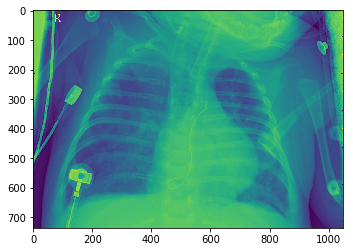

In [27]:
plt.imshow(train_images[0])

In [28]:
max_width = 0
max_height = 0

min_width = 99999
min_height = 99999

for image in train_images:
    if image.shape[0] < min_height:
        min_height = image.shape[0]
    if image.shape[1] < min_width:
        min_width = image.shape[1]
    if image.shape[0] > max_height:
        max_height = image.shape[0]
    if image.shape[1] > max_width:
        max_width = image.shape[1]
        
print("Max dimension: {}x{}".format(max_height, max_width))
print("Min dimension: {}x{}".format(min_height, min_width))

Max dimension: 2663x2916
Min dimension: 127x384


In [62]:
train_images = np.array([skimage.transform.resize(x, (100,250,3)) for x in train_images])
test_images = np.array([skimage.transform.resize(x, (100,250,3)) for x in test_images])
val_images = np.array([skimage.transform.resize(x, (100,250,3)) for x in val_images])

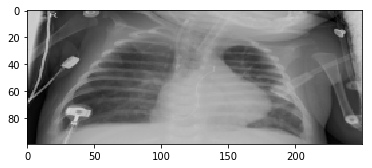

In [63]:
plt.imshow(train_images[0])

In [64]:
train_images.shape

(5216, 100, 250, 3)

In [65]:
train_classes = np.array(train_classes)
test_classes = np.array(test_classes)
val_classes = np.array(val_classes)

### CNN

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [106]:
cnn = Sequential()

cnn.add(Conv2D(filters=100, kernel_size=(3,3), input_shape=(100,250,3), activation="relu"))
cnn.add(BatchNormalization())

cnn.add(Conv2D(filters=50, kernel_size=(3,3), activation="relu"))
cnn.add(BatchNormalization())

cnn.add(Conv2D(filters = 10, kernel_size=(3,3), activation="relu"))
cnn.add(BatchNormalization())

cnn.add(MaxPool2D(strides=(1,1)))
cnn.add(Flatten())

# First fully connected layer
cnn.add(Dense(units=50, activation="relu"))
# Second fully connected layer
cnn.add(Dense(units=20, activation="relu"))
# Output layer
cnn.add(Dense(units=1, activation="sigmoid"))

In [107]:
datagen = ImageDataGenerator(zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, rotation_range=10)

In [108]:
variable_lr = LearningRateScheduler(lambda x: 0.001*0.9**x)

In [109]:
cnn.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

In [ ]:
train_step = cnn.fit_generator(generator = datagen.flow(train_images, train_classes, batch_size = 16), 
                               epochs = 5, 
                               steps_per_epoch = 100, 
                               validation_data=(val_images, val_classes), 
                               callbacks = [variable_lr])

Epoch 1/5
100/100 [==============================] - 645s 6s/step - loss: 4.0165 - acc: 0.7425 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 713s 7s/step - loss: 4.1252 - acc: 0.7412 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 640s 6s/step - loss: 4.0159 - acc: 0.7481 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/5


In [99]:
test_loss, test_acc = cnn.evaluate(test_images, test_classes, verbose=0)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

Test Loss: 0.6104873143709623, Test Accuracy: 0.7580128205128205


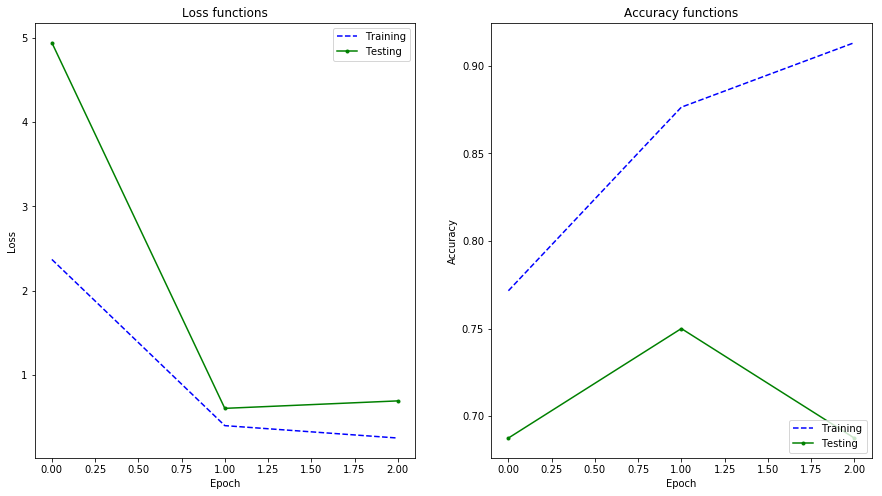

In [102]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(train_step.history["loss"], "b--", label="Training")
plt.plot(train_step.history["val_loss"], "g.-", label="Testing")
plt.title("Loss functions")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.plot(train_step.history["acc"], "b--", label="Training")
plt.plot(train_step.history["val_acc"], "g.-", label="Testing")
plt.title("Accuracy functions")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()